In [81]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import matplotlib.gridspec as gridspec

In [82]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})
client


/home/z3533092/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35538 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35538/status,
Dashboard: http://127.0.0.1:35538/status,Workers: 4
Total threads: 4,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37392,Workers: 4
Dashboard: http://127.0.0.1:35538/status,Total threads: 4
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42239,Total threads: 1
Dashboard: http://127.0.0.1:43788/status,Memory: 28.00 GiB
Nanny: tcp://127.0.0.1:36597,


In [83]:



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False, 
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut

In [84]:
def load_roms(filename,overlap):
    chunks = {'ocean_time': 1}
    glb_files = sorted(glob(filename))
    
    def preprocessRemoveOverlap(ds):
        '''remove the overlap from each file'''
        return ds.isel(ocean_time = slice(0,-overlap))

    for files in glb_files: 
        print(files)
        
    ds = xr.open_mfdataset(glb_files, chunks=chunks, preprocess=preprocessRemoveOverlap, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
    print('Loading data: OK!')
    return ds


# grid.transform(ds.temp.mean(dim='ocean_time'), 'Z', np.array([-500]),target_data=ds.z_rho0,method='linear').squeeze()

In [91]:
enoi = load_roms(filename='/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc',overlap=19)

/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc
Loading data: OK!


In [89]:
enoi.u.nbytes/1e9


90.80026272

In [8]:
enoi = enoi.drop_vars(['sustr','svstr','shflux','ssflux','AKs','AKt','AKv','salt','temp','w','DV_avg1','DV_avg2','ubar','vbar','DU_avg1','DU_avg2'])


In [11]:
enoi.nbytes/1e9

10.076330084

#### data prep

In [38]:
grid = makeROMSGridObject(enoi)
enoi = processROMSGrid(enoi)

In [90]:
EVerything after here is for running in the script - but we don't have enough mem to do this

SyntaxError: invalid syntax (1209930009.py, line 1)

In [34]:
enoi

<xarray.Dataset>
Dimensions:      (tracer: 2, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 240)
Coordinates: (12/14)
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u        (eta_rho, xi_u) float64 147.1 147.1 147.2 ... 162.1 162.1 162.2
    lat_u        (eta_rho, xi_u) float64 -38.5 -38.51 -38.52 ... -28.14 -28.15
    ...           ...
    lon_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2013-02-24 ... 2013-04-04T20:00:00
    z_w          (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
    z_rho0       (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(317, 272, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/78)
    ntimes       int32 ...
    ndtfast      int32 ...
    dt           float64 ...
    dtfast       float64 ...
    dstart       datetime64[ns] ...
    nHIS         int32 ...
    ...           ...
    dz_u         (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u       (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 317, 271), meta=np.ndarray>
    dz_v         (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v       (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 316, 272), meta=np.ndarray>
    dA           (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    mke          (s_rho, eta_rho, xi_rho) float64 nan nan nan ... 0.02765 nan
Attributes: (12/28)
    file:              eac_his.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    rst_file:          eac_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.4, Wednesday - September 16, 2020...
    ana_file:          /home/561/cgk561/eac/forecasts_EnOI_TRADobs/include/an...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [13]:
#### Calculate MKE and EKE
enoi.u.load()
enoi.v.load()

<xarray.DataArray 'v' (ocean_time: 240, s_rho: 30, eta_v: 316, xi_rho: 272)>
array([[[[            nan,             nan,             nan, ...,
           1.06487984e-04,  3.78821538e-04,  3.20879753e-04],
         [            nan,             nan,             nan, ...,
           2.80121239e-02,  3.24033566e-02,  2.62937968e-04],
         [            nan,             nan,             nan, ...,
           2.85240535e-02,  2.81058109e-02,  3.77568878e-05],
         ...,
         [            nan,             nan,             nan, ...,
           1.44899563e-02,  4.49752559e-02,  9.36077546e-03],
         [            nan,             nan,             nan, ...,
           2.53813864e-02,  5.58879705e-02,  1.22798663e-02],
         [            nan,             nan,             nan, ...,
           4.23046819e-02,  1.73405744e-02,  1.48102204e-02]],

        [[            nan,             nan,             nan, ...,
           1.06487984e-04,  3.78821538e-04,  3.20879753e-04],
         [            nan,             nan,             nan, ...,
           6.10836324e-02,  5.11438763e-02,  2.62937968e-04],
         [            nan,             nan,             nan, ...,
           3.93033177e-02,  2.78562256e-02,  3.77568878e-05],
...
         [            nan,             nan,             nan, ...,
          -1.58672182e-01, -1.70160474e-01, -1.75678022e-01],
         [            nan,             nan,             nan, ...,
          -1.53906624e-01, -1.68045216e-01, -1.76126184e-01],
         [            nan,             nan,             nan, ...,
          -1.58125243e-01, -1.74147929e-01, -1.75137881e-01]],

        [[            nan,             nan,             nan, ...,
           2.58755048e-02,  1.29298117e-02,  4.43821082e-03],
         [            nan,             nan,             nan, ...,
           4.71323651e-02,  3.25252780e-02, -4.05320440e-03],
         [            nan,             nan,             nan, ...,
           3.93041087e-02,  2.34976060e-02, -6.80620451e-03],
         ...,
         [            nan,             nan,             nan, ...,
          -1.48991870e-01, -1.58770567e-01, -1.69550766e-01],
         [            nan,             nan,             nan, ...,
          -1.44368495e-01, -1.56974039e-01, -1.70179686e-01],
         [            nan,             nan,             nan, ...,
          -1.52878286e-01, -1.68674866e-01, -1.69428100e-01]]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_v       (eta_v, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_v       (eta_v, xi_rho) float64 -38.48 -38.49 -38.5 ... -28.17 -28.18
  * ocean_time  (ocean_time) datetime64[ns] 2013-02-24 ... 2013-04-04T20:00:00
Dimensions without coordinates: eta_v, xi_rho
Attributes:
    long_name:  v-momentum component
    units:      meter second-1
    time:       ocean_time
    field:      v-velocity, scalar, series

In [21]:
u_bar = grid.interp(enoi.u.mean("ocean_time"),'X')
v_bar = grid.interp(enoi.v.mean("ocean_time"),'Y')
mke = 0.5*(u_bar**2 + v_bar**2)

enoi["mke"] = mke

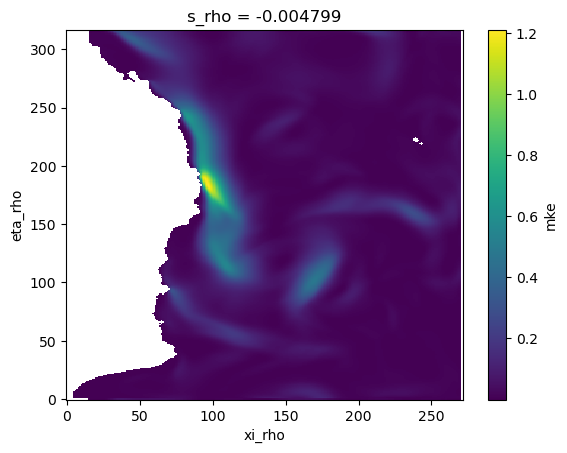

In [24]:

enoi.mke.isel(s_rho=-1).plot()

In [27]:
u_rho = grid.interp(enoi.u,'X')
v_rho = grid.interp(enoi.v,'Y')

print('calc velocity anomalies')
u_prime = u_rho - u_bar
v_prime = v_rho - v_bar

print('calc eke')
eke = 0.5*(u_prime**2 + v_prime**2)

# enoi["eke"] = eke

calc velocity anomalies
calc eke


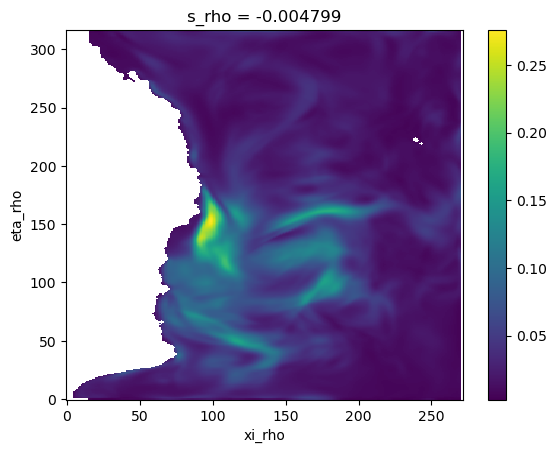

In [28]:
eke.isel(s_rho=-1).mean(dim='ocean_time').plot()

In [71]:
eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
# eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
mke_0_400=mke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

eke_400_1200=grid.average(eke.where((enoi.z_rho<-400)&(enoi.z_rho>-1200)),'Z')
# mke_400_1200=grid.average(mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)),'Z')
mke_400_1200=mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

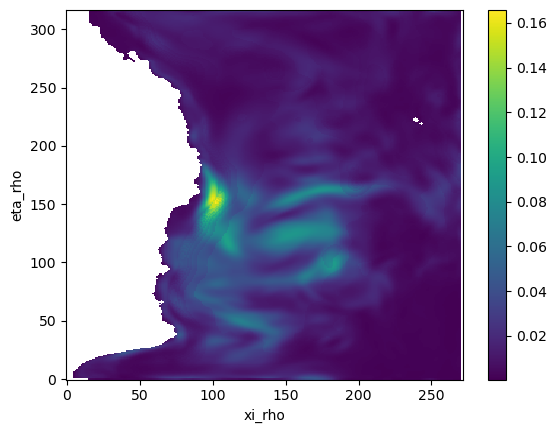

In [68]:
eke_0_400.mean(dim='ocean_time').plot()

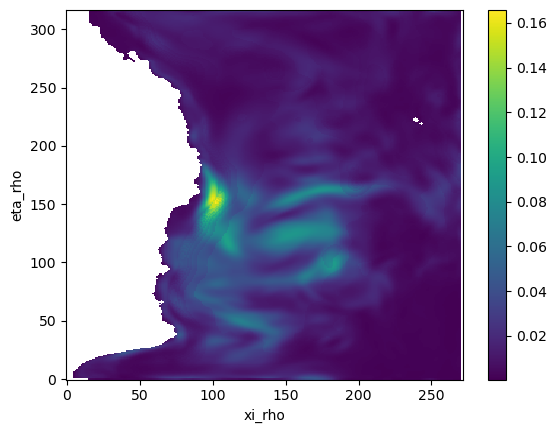

In [70]:
(eke.where(enoi.z_rho>-400).weighted(weights=enoi.dz).mean(dim='s_rho').mean(dim='ocean_time')).plot()

#### Start plotting

In [75]:
Coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
CoastHR = cfeature.GSHHSFeature(scale='auto')

Text(0.01, 0.99, 'd')

<Figure size 640x480 with 0 Axes>

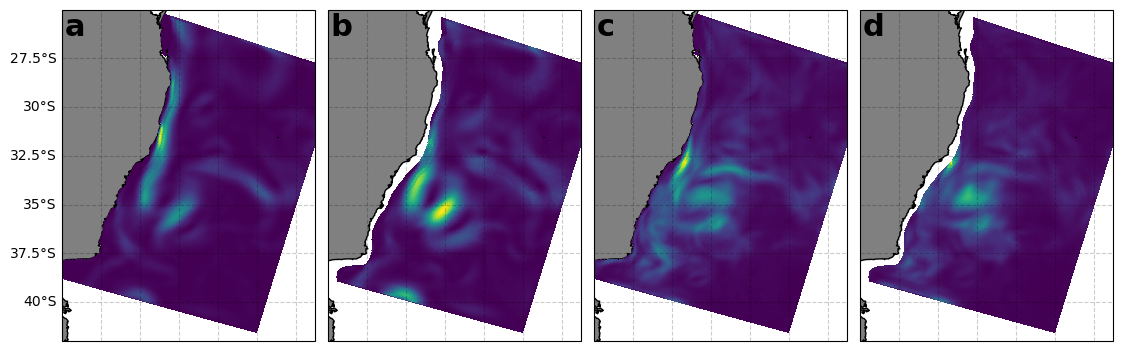

In [79]:



def addSubplot_spatialMap(input,Grid,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(Grid.lon_rho,Grid.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,9])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(mke_0_400,enoi)
# co = truth_eke_0.std(dim='ocean_time').plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.1),colors='black',zorder=12, linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(mke_400_1200,enoi)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(eke_0_400.mean(dim='ocean_time'),enoi)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(eke_400_1200.mean(dim='ocean_time'),enoi)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

# ax.text(-.26, .5, 'EKE (0 m) & RMSE',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'Ref state',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
